<a href="https://colab.research.google.com/github/NoviceCoder2/NoviceCoder2/blob/main/McDonald's_Fast_Food_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd


mcdonalds = pd.read_csv("/content/mcdonalds.csv")
# Inspect the data
mcdonalds.columns
mcdonalds.shape
mcdonalds.head(3)




,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female


# **Convert YES/NO to Binary **

In [2]:
import numpy as np

# Convert YES/NO to binary numeric
MD_x = mcdonalds.iloc[:, 0:11].applymap(lambda x: 1 if x == "Yes" else 0)

# Calculate column means
col_means = MD_x.mean().round(2)
print(col_means)


yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64


**Principal Components Analysis (PCA)**

In [3]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA()
MD_pca = pca.fit(MD_x)

# Summary of PCA
print("Explained variance ratio:", pca.explained_variance_ratio_.round(4))
print("Cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_).round(4))

# Print PCA components
components = pd.DataFrame(pca.components_, columns=MD_x.columns)
print(components.round(1))


Explained variance ratio: [0.2994 0.1928 0.133  0.0831 0.0595 0.0503 0.0438 0.0395 0.0368 0.0324
 0.0293]
Cumulative explained variance: [0.2994 0.4922 0.6253 0.7084 0.7679 0.8182 0.862  0.9016 0.9383 0.9707
 1.    ]
    yummy  convenient  spicy  fattening  greasy  fast  cheap  tasty  \
0    -0.5        -0.2   -0.0        0.1     0.3  -0.1   -0.3   -0.5   
1     0.4         0.0    0.0       -0.0    -0.1  -0.1   -0.6    0.3   
2    -0.3        -0.1   -0.0       -0.3    -0.8  -0.1   -0.1   -0.3   
3     0.1        -0.1    0.2       -0.4     0.3  -0.1    0.1   -0.0   
4    -0.3         0.3    0.1       -0.1     0.4   0.1   -0.1   -0.2   
5     0.2        -0.3   -0.4       -0.4     0.2  -0.6   -0.1   -0.1   
6    -0.3        -0.1    0.7       -0.4     0.0  -0.1   -0.0    0.4   
7     0.0        -0.1    0.4        0.6    -0.1  -0.6    0.1   -0.1   
8     0.6        -0.0    0.4       -0.2    -0.0   0.2    0.1   -0.6   
9    -0.1        -0.7   -0.1       -0.0     0.0   0.2    0.4    0.1   
10

**Plot the Perceptual Map**

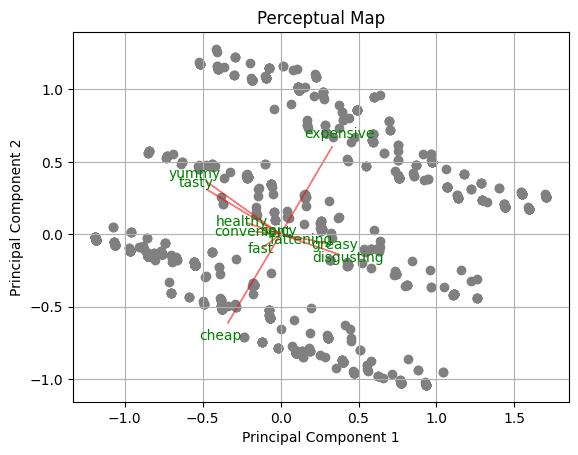

In [4]:
import matplotlib.pyplot as plt

# Project data into the first two principal components
projected = pca.transform(MD_x)

# Plot the perceptual map
plt.scatter(projected[:, 0], projected[:, 1], color='grey')

# Adding arrows for the original segmentation variables
for i, (comp1, comp2) in enumerate(zip(pca.components_[0], pca.components_[1])):
    plt.arrow(0, 0, comp1, comp2, color='r', alpha=0.5)
    plt.text(comp1 * 1.15, comp2 * 1.15, MD_x.columns[i], color='g', ha='center', va='center')

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Perceptual Map")
plt.grid()
plt.show()


**k-Means Clustering**

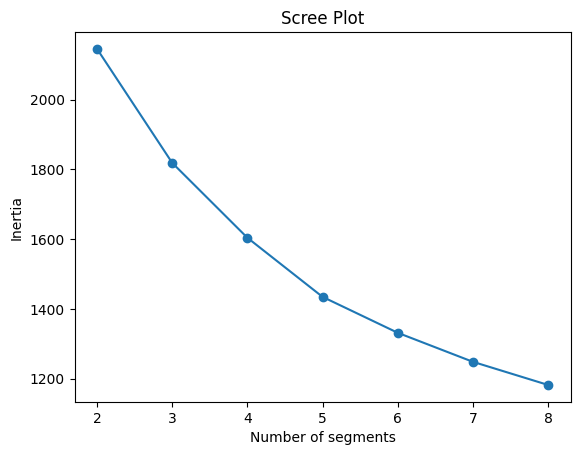

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample
import matplotlib.pyplot as plt

# Perform k-means clustering for 2 to 8 segments with 10 random restarts
def run_kmeans(data, k, n_init=10):
    kmeans = KMeans(n_clusters=k, n_init=n_init, random_state=1234)
    kmeans.fit(data)
    return kmeans

kmeans_models = [run_kmeans(MD_x, k) for k in range(2, 9)]

# Plot the scree plot
inertia = [model.inertia_ for model in kmeans_models]
plt.plot(range(2, 9), inertia, marker='o')
plt.xlabel("Number of segments")
plt.ylabel("Inertia")
plt.title("Scree Plot")
plt.show()


**Global Stability with Bootstrapping**

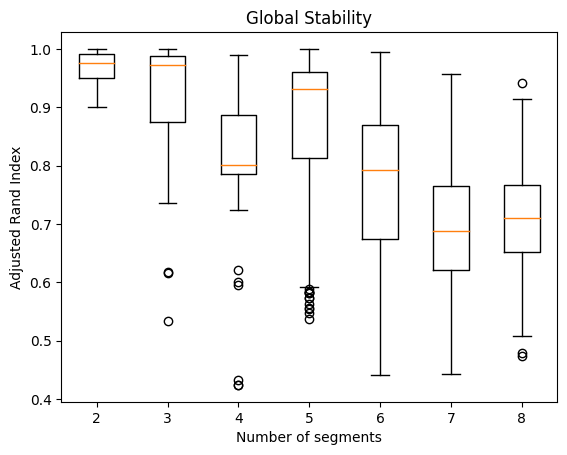

In [6]:
def boot_kmeans(data, k, n_init=10, nboot=100):
    stability_scores = []
    for i in range(nboot):
        boot_sample = resample(data, replace=True, random_state=i)
        model = run_kmeans(boot_sample, k, n_init=n_init)
        labels = model.predict(data)
        stability_scores.append(adjusted_rand_score(labels, run_kmeans(data, k, n_init=n_init).labels_))
    return stability_scores

# Calculate stability for each k
stability_scores = {k: boot_kmeans(MD_x, k) for k in range(2, 9)}

# Plot the global stability boxplot
plt.boxplot([stability_scores[k] for k in range(2, 9)], labels=range(2, 9))
plt.xlabel("Number of segments")
plt.ylabel("Adjusted Rand Index")
plt.title("Global Stability")
plt.show()


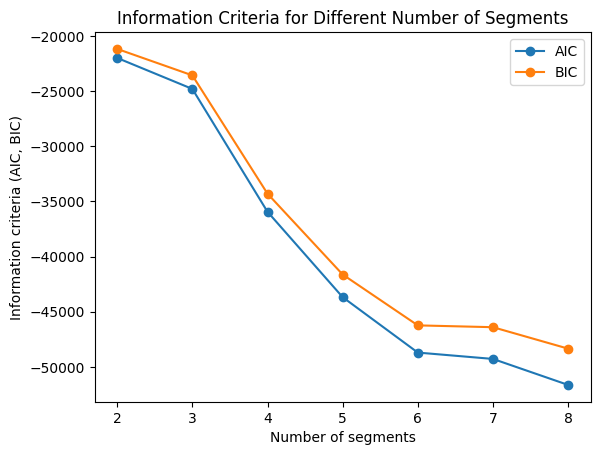

In [7]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from statsmodels.tools.tools import add_constant

# Function to fit the mixture model for binary data
def fit_finite_mixture(data, k_range, n_init=10):
    models = []
    for k in k_range:
        model = GaussianMixture(n_components=k, covariance_type='full', n_init=n_init, random_state=1234)
        model.fit(data)
        models.append(model)
    return models

# Fit the model for k = 2 to 8
k_range = range(2, 9)
mixture_models = fit_finite_mixture(MD_x, k_range)

# Extract information criteria
aic = [model.aic(MD_x) for model in mixture_models]
bic = [model.bic(MD_x) for model in mixture_models]

# Plot the information criteria
plt.plot(k_range, aic, marker='o', label='AIC')
plt.plot(k_range, bic, marker='o', label='BIC')
plt.xlabel("Number of segments")
plt.ylabel("Information criteria (AIC, BIC)")
plt.legend()
plt.title("Information Criteria for Different Number of Segments")
plt.show()


In [9]:
best_model = mixture_models[2]
from sklearn.cluster import KMeans

# Run k-means with 4 segments
kmeans_4 = KMeans(n_clusters=4, random_state=1234).fit(MD_x)

# Predict the cluster labels for k-means and mixture model
kmeans_labels = kmeans_4.labels_
mixture_labels = best_model.predict(MD_x)

# Create a cross-tabulation
cross_tab = pd.crosstab(kmeans_labels, mixture_labels, rownames=['kmeans'], colnames=['mixture'])
print(cross_tab)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


mixture    0   1   2    3
kmeans                   
0        449   1  42   21
1        288  36   5   37
2          0  87   2  153
3          0   8  77  247


In [10]:
# Initialize mixture model with k-means labels
initial_model = GaussianMixture(n_components=4, covariance_type='full', n_init=1, random_state=1234)
initial_model.fit(MD_x, y=kmeans_labels)

# Predict the cluster labels
initial_labels = initial_model.predict(MD_x)

# Create a cross-tabulation
initial_cross_tab = pd.crosstab(kmeans_labels, initial_labels, rownames=['kmeans'], colnames=['mixture'])
print(initial_cross_tab)


mixture   0    1   2    3
kmeans                   
0        20  302   0  191
1         2  116  59  189
2        90   30  14  108
3        17  150   1  164


In [11]:
log_likelihood_initial = initial_model.score(MD_x) * MD_x.shape[0]
log_likelihood_best = best_model.score(MD_x) * MD_x.shape[0]

print(f'Log Likelihood (initial): {log_likelihood_initial}')
print(f'Log Likelihood (best): {log_likelihood_best}')


Log Likelihood (initial): 17040.598827012964
Log Likelihood (best): 18280.115101343403


Component 1
                            OLS Regression Results                            
Dep. Variable:                 Like_n   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 27 May 2024   Prob (F-statistic):                nan
Time:                        10:17:22   Log-Likelihood:                 157.09
No. Observations:                   5   AIC:                            -304.2
Df Residuals:                       0   BIC:                            -306.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6327        inf        

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1796: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1796: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1718: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 

Intercept     0.632653
yummy         0.020408
convenient   -2.020408
spicy         0.040816
fattening     0.591837
greasy       -1.479592
fast         -1.479592
cheap        -0.959184
tasty         1.591837
expensive     1.551020
healthy       0.632653
disgusting   -0.918367
dtype: float64
P-values:
Intercept    NaN
yummy        NaN
convenient   NaN
spicy        NaN
fattening    NaN
greasy       NaN
fast         NaN
cheap        NaN
tasty        NaN
expensive    NaN
healthy      NaN
disgusting   NaN
dtype: float64
Component 2 Params:
Intercept    -0.400844
yummy        -2.945148
convenient    2.561181
spicy         1.561181
fattening    -1.080169
greasy        4.358650
fast         -2.945148
cheap        -4.080169
tasty        -3.109705
expensive    -0.164557
healthy       0.000000
disgusting   -0.164557
dtype: float64
P-values:
Intercept    NaN
yummy        NaN
convenient   NaN
spicy        NaN
fattening    NaN
greasy       NaN
fast         NaN
cheap        NaN
tasty        NaN
expens

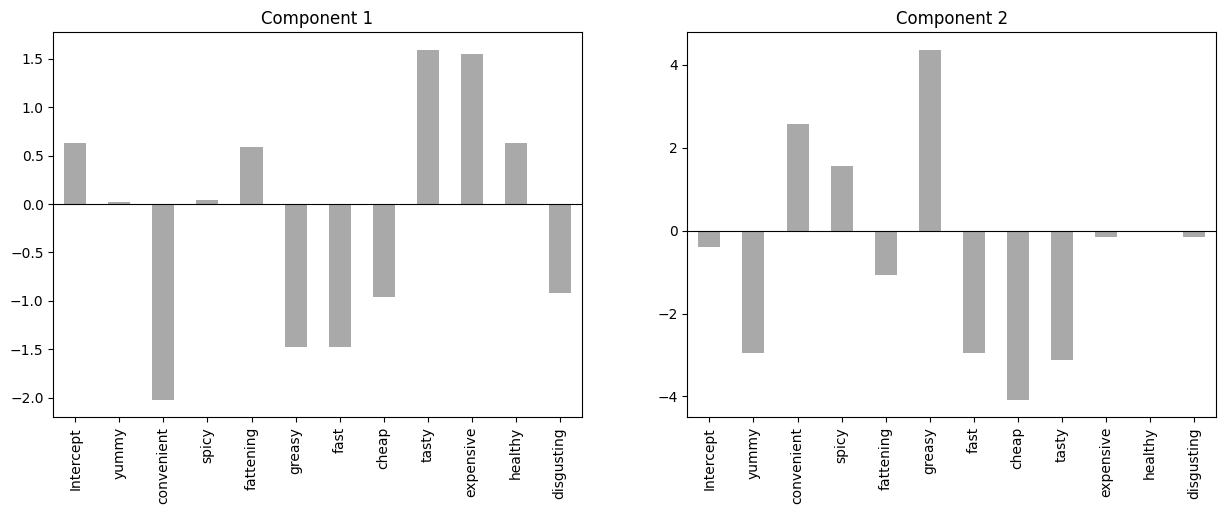

In [16]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.mixture import GaussianMixture
from patsy import dmatrices
import matplotlib.pyplot as plt

# Sample data to mimic the structure
data = {
    'Like': ['I love it!+5', '+4', '+3', '+2', '+1', '0', '-1', '-2', '-3', '-4', 'I hate it!-5'],
    'yummy': np.random.randint(0, 2, size=11),
    'convenient': np.random.randint(0, 2, size=11),
    'spicy': np.random.randint(0, 2, size=11),
    'fattening': np.random.randint(0, 2, size=11),
    'greasy': np.random.randint(0, 2, size=11),
    'fast': np.random.randint(0, 2, size=11),
    'cheap': np.random.randint(0, 2, size=11),
    'tasty': np.random.randint(0, 2, size=11),
    'expensive': np.random.randint(0, 2, size=11),
    'healthy': np.random.randint(0, 2, size=11),
    'disgusting': np.random.randint(0, 2, size=11)
}
mcdonalds = pd.DataFrame(data)

# Mapping the 'Like' column to numeric values
like_mapping = {
    'I hate it!-5': -5, '-4': -4, '-3': -3, '-2': -2, '-1': -1, '0': 0,
    '+1': 1, '+2': 2, '+3': 3, '+4': 4, 'I love it!+5': 5
}
mcdonalds['Like_n'] = mcdonalds['Like'].map(like_mapping)

# Create formula for regression model
independent_vars = ['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap', 'tasty', 'expensive', 'healthy', 'disgusting']
formula = 'Like_n ~ ' + ' + '.join(independent_vars)

# Extract data for the regression model
y, X = dmatrices(formula, data=mcdonalds, return_type='dataframe')

# Fit Gaussian Mixture Model to find the latent classes
gmm = GaussianMixture(n_components=2, n_init=10, random_state=1234)
gmm.fit(X)
labels = gmm.predict(X)

# Add labels to the DataFrame
mcdonalds['label'] = labels

# Fit separate regression models for each component
results = []
for label in np.unique(labels):
    model = smf.ols(formula, data=mcdonalds[mcdonalds['label'] == label]).fit()
    results.append(model)

# Print summaries for each component
for i, result in enumerate(results, start=1):
    print(f"Component {i}")
    print(result.summary())

# Plot regression coefficients for each component
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, result in enumerate(results):
    params = result.params

    # Debugging statements
    print(f"Component {i+1} Params:")
    print(params)
    print("P-values:")
    print(result.pvalues)

    if not params.empty:
        params.plot(kind='bar', ax=axes[i], color=['gray' if p > 0.05 else 'darkgray' for p in result.pvalues])
        axes[i].set_title(f'Component {i+1}')
        axes[i].axhline(0, color='black', linewidth=0.8)
    else:
        print(f"No params to plot for Component {i+1}")

plt.show()


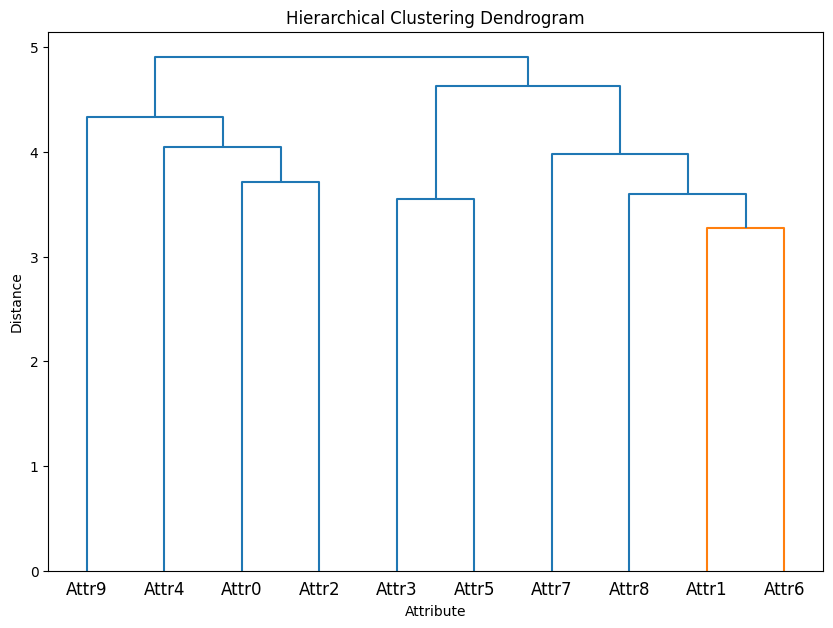

In [18]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
import matplotlib.pyplot as plt
import seaborn as sns

# Example synthetic data
np.random.seed(0)
MD_x = pd.DataFrame(np.random.rand(100, 10), columns=[f'Attr{i}' for i in range(10)])

# Transpose the data and calculate the distance matrix
dist_matrix = pdist(MD_x.T, metric='euclidean')

# Perform hierarchical clustering
MD_vclust = linkage(dist_matrix, method='ward')

# Optional: Dendrogram plot to visualize hierarchical clustering
plt.figure(figsize=(10, 7))
dendrogram(MD_vclust, labels=MD_x.columns)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Attribute')
plt.ylabel('Distance')
plt.show()

# Get the order of leaves from hierarchical clustering
order = leaves_list(MD_vclust)


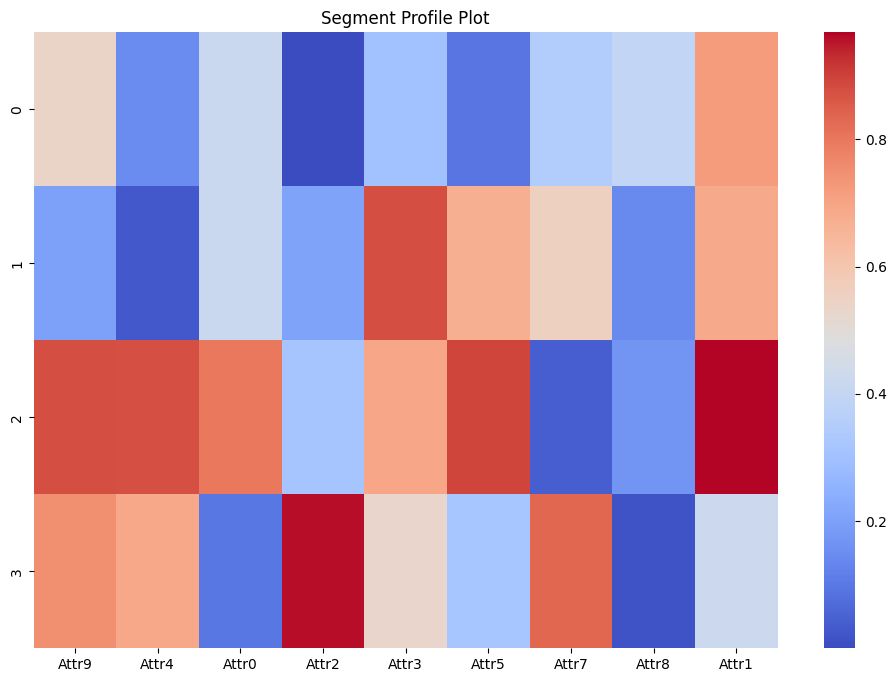

In [20]:
# Example synthetic segment data for demonstration purposes
np.random.seed(1)
MD_k4 = pd.DataFrame(np.random.rand(4, 10), columns=[f'Attr{i}' for i in range(10)])
MD_k4['Segment'] = [1, 2, 3, 4]  # Adding segment labels

# Reorder columns in MD_k4 according to hierarchical clustering order
MD_k4_reordered = MD_k4.iloc[:, order]

# Plot segment profile plot
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(MD_k4_reordered.iloc[:, :-1], cmap='coolwarm', cbar=True, ax=ax)
ax.set_title('Segment Profile Plot')
plt.show()


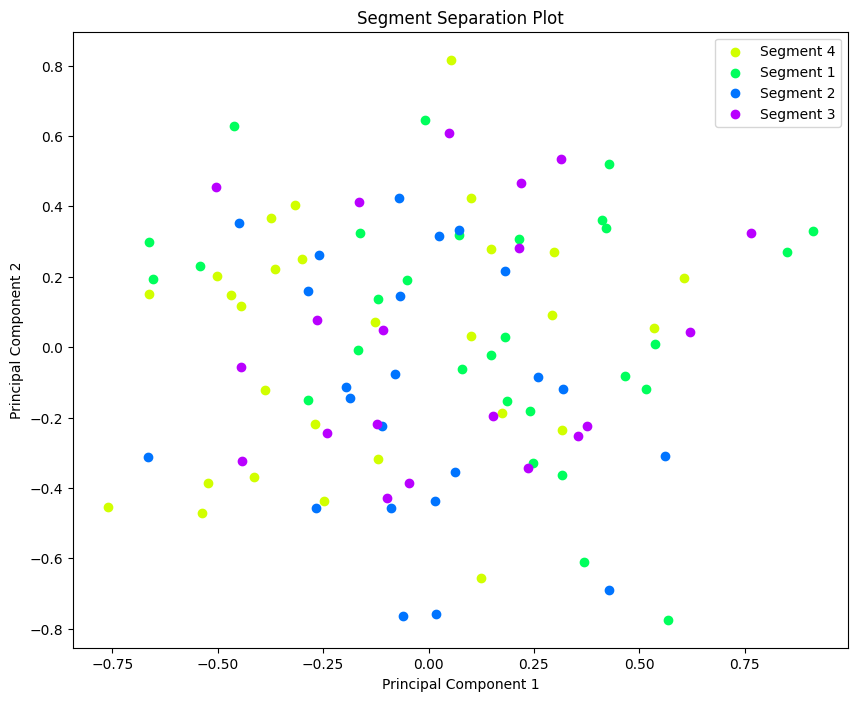

In [21]:
from sklearn.decomposition import PCA

# Perform PCA on the original data
pca = PCA(n_components=2)
MD_pca = pca.fit_transform(MD_x)

# Create a DataFrame with PCA results and segment labels
# Example: Assigning random segments for demonstration
segments = np.random.choice([1, 2, 3, 4], size=MD_x.shape[0])
pca_df = pd.DataFrame(MD_pca, columns=['PC1', 'PC2'])
pca_df['Segment'] = segments

# Plot segment separation plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each segment
unique_segments = pca_df['Segment'].unique()
colors = sns.color_palette('hsv', len(unique_segments))

for segment, color in zip(unique_segments, colors):
    segment_data = pca_df[pca_df['Segment'] == segment]
    ax.scatter(segment_data['PC1'], segment_data['PC2'], label=f'Segment {segment}', color=color)

# Add labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Segment Separation Plot')
ax.legend()

plt.show()



**Mosaic Plot for Love or Hate McDonald's**

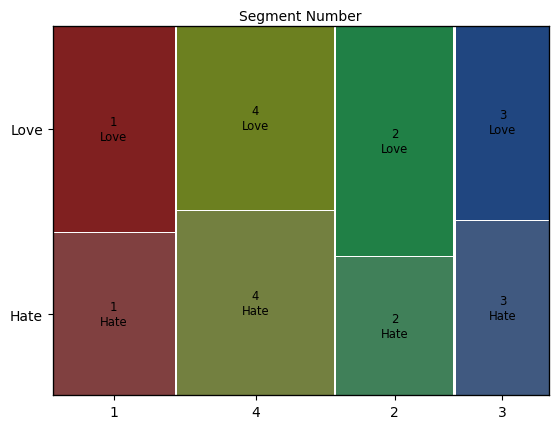

In [25]:
import pandas as pd
import numpy as np
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt

# Assuming k4 is the cluster labels and Like is the variable for love or hate McDonald's
# Example data for demonstration purposes
np.random.seed(0)
k4 = np.random.choice([1, 2, 3, 4], size=100)
Like = np.random.choice(['Love', 'Hate'], size=100)

# Create a DataFrame with cluster labels and Like variable
data = {'Segment Number': k4, 'Love or Hate': Like}
df = pd.DataFrame(data)

# Generate the mosaic plot
mosaic(df, ['Segment Number', 'Love or Hate'], title='')
plt.xlabel('Segment Number')
plt.show()


**Mosaic Plot for Gender Distribution**

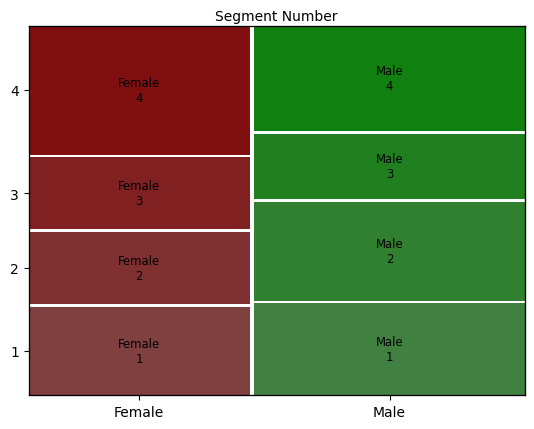

In [28]:
import pandas as pd
import numpy as np
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt

# Example data for demonstration purposes
np.random.seed(0)
k4 = np.random.choice([1, 2, 3, 4], size=100)
Gender = np.random.choice(['Male', 'Female'], size=100)

# Create a DataFrame with cluster labels and Gender variable
data_gender = {'Segment Number': k4, 'Gender': Gender}
df_gender = pd.DataFrame(data_gender)

# Generate the contingency table for gender distribution
contingency_table_gender = pd.crosstab(df_gender['Segment Number'], df_gender['Gender'])

# Set the index of the contingency table
contingency_table_gender.index.name = 'Segment Number'

# Generate the mosaic plot for gender distribution
mosaic(contingency_table_gender.unstack(), gap=0.01, title='')
plt.xlabel('Segment Number')
plt.show()


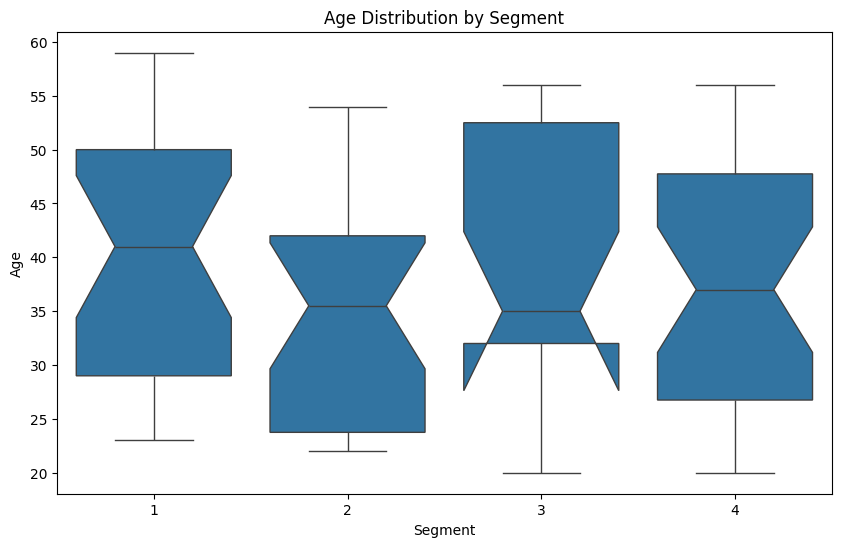

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example data for demonstration purposes
np.random.seed(0)
k4 = np.random.choice([1, 2, 3, 4], size=100)
Age = np.random.randint(20, 60, size=100)

# Create a DataFrame with cluster labels and Age variable
data_age = {'Segment': k4, 'Age': Age}
df = pd.DataFrame(data_age)

# Generate the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Segment', y='Age', data=df, notch=True)
plt.xlabel('Segment')
plt.ylabel('Age')
plt.title('Age Distribution by Segment')
plt.show()


**Conditional Inference Tree for Predicting Segment Membership**

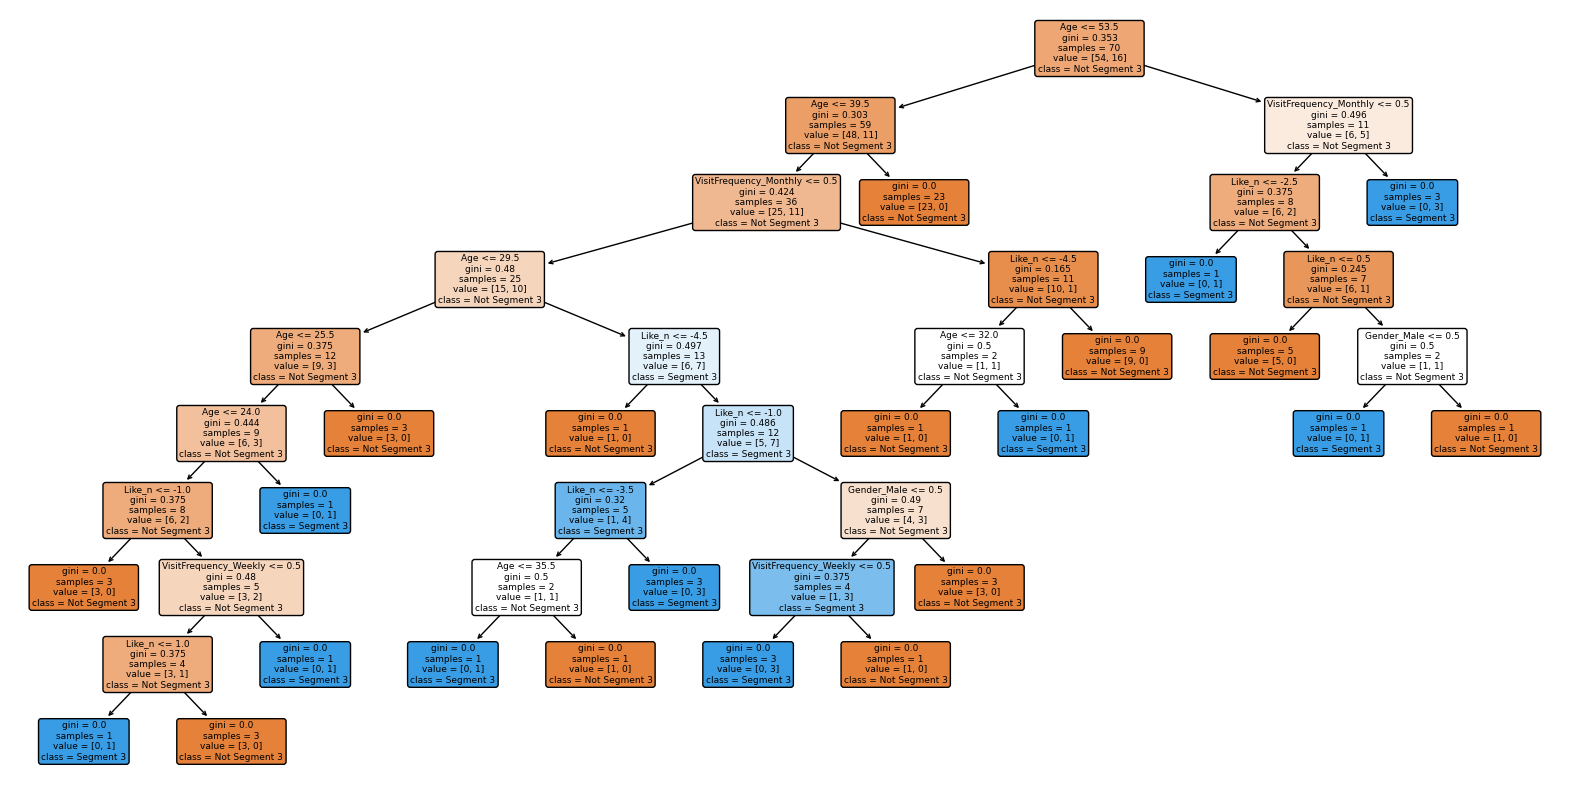

In [31]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

# Example data for demonstration purposes
Like_n = np.random.randint(-5, 5, size=100)
VisitFrequency = np.random.choice(['Daily', 'Weekly', 'Monthly'], size=100)
Gender = np.random.choice(['Male', 'Female'], size=100)

# Create a DataFrame
df = pd.DataFrame({
    'Segment': k4,
    'Like_n': Like_n,
    'Age': Age,
    'VisitFrequency': VisitFrequency,
    'Gender': Gender
})

# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=['VisitFrequency', 'Gender'], drop_first=True)

# Define the target variable and features
X = df_encoded.drop(columns=['Segment'])
y = df_encoded['Segment'] == 3

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Train the decision tree classifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['Not Segment 3', 'Segment 3'], rounded=True)
plt.show()


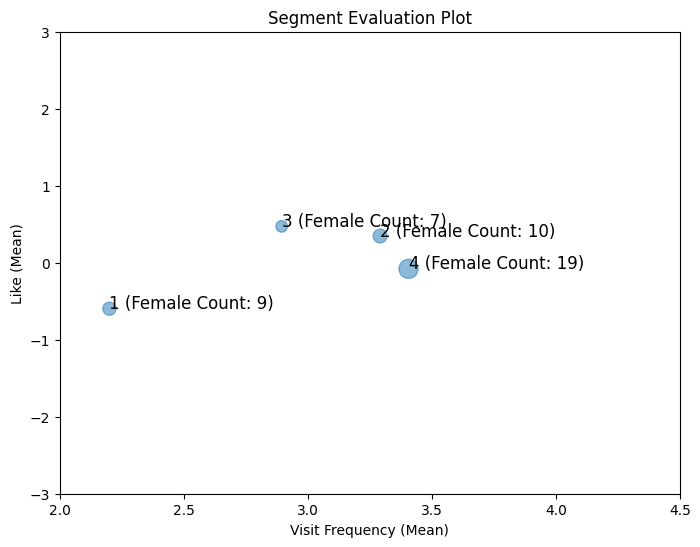

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example data for demonstration purposes
np.random.seed(0)
k4 = np.random.choice([1, 2, 3, 4], size=100)
VisitFrequency = np.random.randint(1, 6, size=100)  # Assuming VisitFrequency is on a scale of 1-5
Like_n = np.random.uniform(-3, 3, size=100)  # Assuming Like_n ranges from -3 to 3
Gender = np.random.choice(['Male', 'Female'], size=100)

# Create a DataFrame with segment labels and variables
data_segment = {'Segment': k4, 'VisitFrequency': VisitFrequency, 'Like_n': Like_n, 'Gender': Gender}
df = pd.DataFrame(data_segment)

# Calculate mean values for VisitFrequency and Like_n by segment
mean_values = df.groupby('Segment').agg({'VisitFrequency': 'mean', 'Like_n': 'mean'})

# Count the number of females by segment
female_count = df[df['Gender'] == 'Female'].groupby('Segment').size()

# Create the segment evaluation plot
plt.figure(figsize=(8, 6))
plt.scatter(mean_values['VisitFrequency'], mean_values['Like_n'], s=10 * female_count, alpha=0.5)
plt.xlim(2, 4.5)
plt.ylim(-3, 3)
plt.xlabel('Visit Frequency (Mean)')
plt.ylabel('Like (Mean)')
plt.title('Segment Evaluation Plot')
for segment, count in female_count.items():
    plt.text(mean_values.loc[segment, 'VisitFrequency'], mean_values.loc[segment, 'Like_n'],
             str(segment) + f' (Female Count: {count})', fontsize=12)
plt.show()
